# Smoothing, Resampling, and Groupby operations with Pandas Dataframes


## Description

This notebook expands on the previous ones shared in wattle by showing how to:
- Smooth a time-series to remove a noisy signal in a satellite time-series.
- Resample a time-series to a different temporal frequency. e.g Resampling a monthly time-series to annual. It also simplifies how the pandas dataframe was 'wrangled' into a nicer structure, in the previous notebook the 'pd.melt' code was a bit too esoteric.
- Doing 'groupby' operations where we can summarise a time-series to get the typical (average) values for a given time-interval (like seasons, month, etc.)

We will:
1. Load a shapefile (a common vector file format) delineating the Murray-Darling-Basin (I found this shapefile online), and convert it to a geojson.
2. Load a timeseries of MODIS NDVI within the limits of the geojson
3. Load the Global Forest Change product, thesholding it to create a 'mask' of trees/not-trees (AKA a binary mask)
4. Mask the MODIS NDVI product with the 'trees' mask.
5. Extract the time-series and plot.
6. Smooth the time-series using rolling means - we do this to remove 'noise' from a satellite time-series. This is common in phenology analysis.
7. Resample a time-series to show longer term trends.
8. Calculate monthly and dayofyear climatolgies to show the typical annual cycle of the time-series.

## Load packages

Import Python packages that are used for the analysis.


In [1]:
%matplotlib inline

import ee
import eemont
import geemap as gmap
import geemap.colormaps as cm
import pandas as pd
import numpy as np
import seaborn as sb
import geopandas as gpd
from matplotlib import pyplot as plt

### Connect to Google Earth Engine (GEE)

In [2]:
Map = gmap.Map()

***

## Open the shapefile and convert to geojson

In [3]:
# #open file
# gdf = gpd.read_file('/scratch/du53/cb3058/mdb_boundary.shp')

# #convert to wgs84 (only projectioj that works with geojson)
# gdf = gdf.to_crs('epsg:4326')

# #export to file for use later
# gdf.to_file('/scratch/du53/cb3058/mdb_boundary.geojson')

## Load MODIS NDVI ImageCollection over a region specified by the MDB


In [4]:
## open the goejson and convert to ee object
geometry = gmap.geojson_to_ee('/scratch/du53/al0850/project/data/mdb_boundary.geojson')
Map.centerObject(geometry)
Map.addLayerControl()

In [5]:
#load the MODIS NDVI product
ndvi = (ee.ImageCollection('MODIS/061/MOD13A1')
                  .filterBounds(geometry) # filter to MDB
                  .map(lambda image: image.clip(geometry)) #clip the data to MDB
                  .filterDate('2017-01-01', '2022-12-31') #timeseries
                  .preprocess() #this will do the rescaling
                  .select('NDVI') #just select the NDVI band
     )

#define a visualization dict
NDVI_vis = {'min':0, 'max':1,
           'palette':list(cm.palettes.ndvi),
           }

# Plot the first time-step
Map.addLayer(ndvi.first(), NDVI_vis, 'NDVI')
Map.add_colorbar(NDVI_vis['palette'],caption='NDVI')

## Load the GFC treecover layer and create a mask

In [6]:
#load gfc
gfc = (ee.Image('UMD/hansen/global_forest_change_2022_v1_10')
       .select('treecover2000')
       .clip(geometry)
      )

# create a binary mask where treecover is greater than 25 %
trees_mask = gfc.gt(25)


## Now mask the NDVI data with the 'tree mask' and plot

In [7]:
#mask ndvi so only places with trees remain
ndvi = ndvi.map(lambda image: image.updateMask(trees_mask))

# Plot again, including the tree mask (mask trees_mask with itself so 0's don't plot)
Map.addLayer(trees_mask.updateMask(trees_mask),
    {'palette': ['000000', '00FF00'], 'max': 1}, 'Trees');

#add the long-term mean ndvi to the map
Map.addLayer(ndvi.mean(), NDVI_vis, 'NDVI')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Generate a time-series for trees in the MDB

### Calculate the time series for trees in MDB

- `Image Collection`: MODIS NDVI
- `bands` NDVI
- `geometry`: the MDB
- `reducer` staistics to compute over the x,y dimension: e.g. minimum, mean, maximum, median
- `scale`: This MODIS product has a resolution of 500m



In [8]:
ts = ndvi.getTimeSeriesByRegion(geometry = geometry,
                              bands = ['NDVI'], #which bands are we summarising?
                              reducer = [ee.Reducer.mean()], #lets take the mean of the pixels
                              scale = 500)

### Convert the time-series to a Pandas Dataframe

In [9]:
# convert to a pandas dataframe
ts_df = gmap.ee_to_pandas(ts)

#convert dat column to datetime
ts_df['date'] = pd.to_datetime(ts_df['date'],
                               infer_datetime_format = True)

#make the index of dataframe the time stamps, and further clean up df
ts_df = ts_df.set_index('date').drop('reducer', axis=1)

ts_df.head() #print the top 5 rows

,NDVI
date,
2017-01-01,0.625889
2017-01-17,0.648344
2017-02-02,0.639376
2017-02-18,0.642903
2017-03-06,0.665345


### Plot

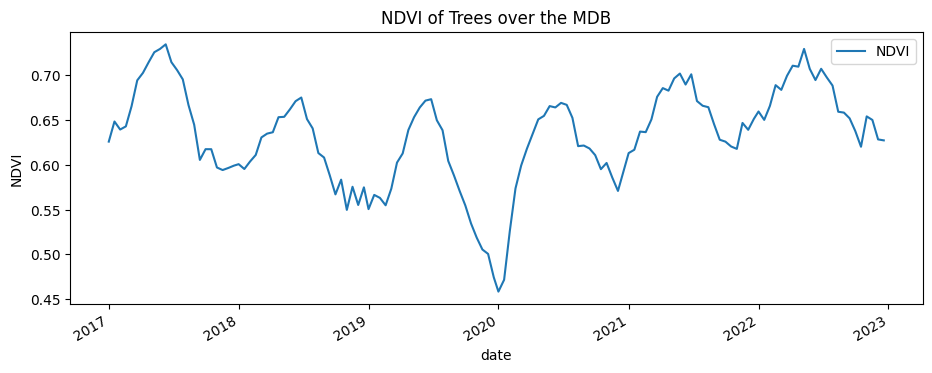

In [10]:
#now plot
ts_df.plot(figsize = (11,4))
plt.title('NDVI of Trees over the MDB');
plt.ylabel('NDVI');

### Smoothing a time-series using rolling means

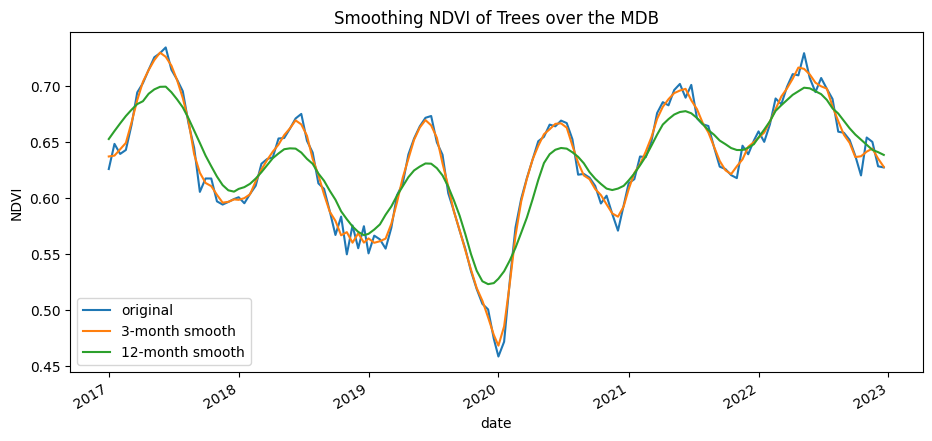

In [11]:
# create figure object
fig,ax = plt.subplots(1,1, figsize=(11,5))

#plot the raw timesries
ts_df.plot(ax=ax, legend=False)

#using the pandas function 'rolling' to smooth the timeseries. 
ts_df.rolling(3, min_periods=1, center=True).mean().plot(ax=ax, legend=False) #3-month rolling mean
ts_df.rolling(12, min_periods=1, center=True).mean().plot(ax=ax, legend=False) #12-month rolling mean

#make the plot nice
ax.legend(["original", "3-month smooth", "12-month smooth"]);
plt.title('Smoothing NDVI of Trees over the MDB');
plt.ylabel('NDVI');

## Resampling time-series

These plots will appear 'offset' because the time-stamp is set at the _end_ of the time-period being resampled

In [12]:
#resample time time seasonal starting in DEC (i.e. meterological seasons)
ts_df_seasonal = ts_df.resample('Q-DEC').mean()

#resample to annual
ts_df_annual = ts_df.resample('A').mean() #'A' for annual

### Plot

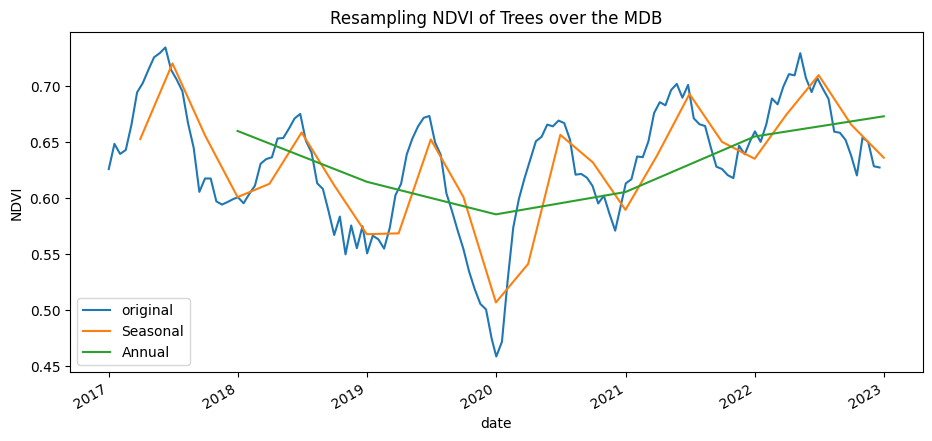

In [13]:
fig,ax = plt.subplots(1,1, figsize=(11,5))
ts_df.plot(ax=ax, legend=False)
ts_df_seasonal.plot(ax=ax, legend=False)
ts_df_annual.plot(ax=ax, legend=False)
ax.legend(["original", "Seasonal", "Annual"]);
plt.title('Resampling NDVI of Trees over the MDB');
plt.ylabel('NDVI');

## Groupby operations

Pandas also provides some shortcuts for aggregating data over time. In the example below, we first group our data by month, then take the mean of each group. This produces a new timee-series with only 12 observations (one per month). This represents the typical monthly response of the time-series, ie. it shows the average of all the jans, all the febs, etc.

In [14]:
#monthly climatology
monthly_climatology = ts_df.groupby(ts_df.index.month).mean()

#dayofyear climatology
doy_climatology = ts_df.groupby(ts_df.index.dayofyear).mean()

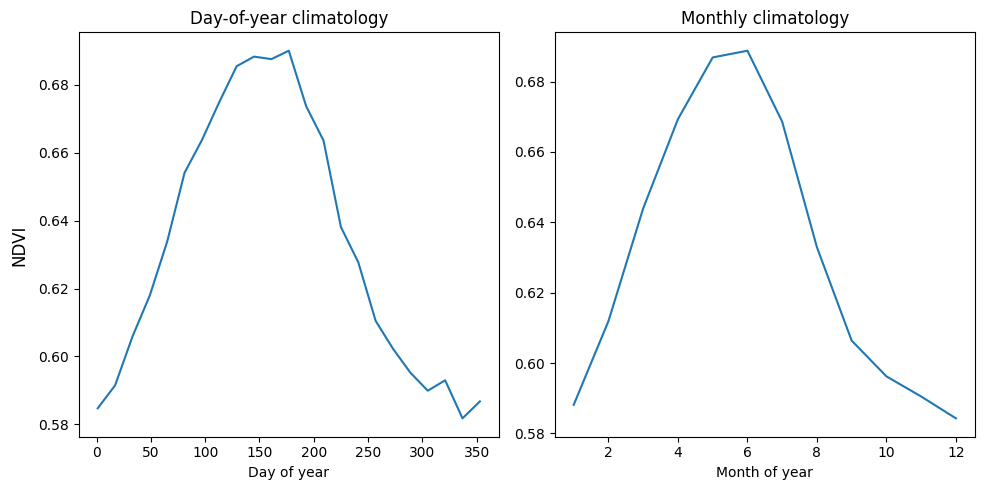

In [15]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
doy_climatology.plot(ax=ax[0], legend=False)
monthly_climatology.plot(ax=ax[1], legend=False)
fig.supylabel('NDVI')
ax[0].set_title('Day-of-year climatology')
ax[1].set_title('Monthly climatology')
ax[0].set_xlabel('Day of year')
ax[1].set_xlabel('Month of year')
plt.tight_layout()


***